In [1]:
#----------------standard packages------------------
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

#-----------------caio's modules---------------------
import sys, os #add code folder to sys.path
sys.path.append(os.path.abspath('../data_processing'))
sys.path.append(os.path.abspath('../classification_models/player_model'))

from pipeline import player_wrangle, player_model

from cricsheet_read import cricsheet_read #data processing

#---------------------load data----------------------
match_stack, results = cricsheet_read()
results = results.join(pd.read_csv('../../data/betfair_data.csv',dtype = {'match_id':str}).set_index('match_id'))
results = results.sort_values('start_date')

In [8]:
test_date = dt.datetime.strptime('2019-06-02', '%Y-%m-%d').date()
match_data = player_wrangle(match_stack, results, min_player_matches = 14)
test_data = player_model(match_data, results, test_date, algorithm = 'forest')

In [9]:
#-----------------caio's modules---------------------
import sys, os #add code folder to sys.path
sys.path.append(os.path.abspath('../archive'))

from backtest import backtest

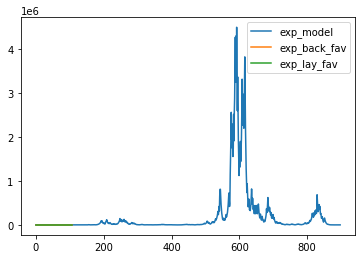

              exp_model  exp_back_fav  exp_lay_fav
return              NaN           NaN          NaN
t-confidence  50.007171           NaN          NaN


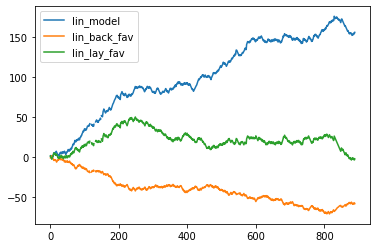

              lin_model  lin_back_fav  lin_lay_fav
return        17.555523     -6.494187    -0.261693
t-confidence  99.999730      0.927408    47.447955


In [10]:
backtest(test_data, 0)

In [ ]:
test_date = dt.datetime.strptime('2020-01-01', '%Y-%m-%d').date()
for match_date in results[results['start_date'] > test_date]

In [ ]:
bet = ((test_data['set_value'] > 0.2)*(test_data['set_team'] == test_data['result']) +
       
       
       
       
       
       (test_data['chase_value'] > 0.2)*(test_data['chase_team'] == test_data['result'])

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as scp
import Levenshtein

def backtest(data,betfair_data,lev_num=4):
    
    temp_data=data.copy()

    temp_data['set_team'] = temp_data['set_team'].str.replace(' ', '')
    temp_data['chase_team'] = temp_data['chase_team'].str.replace(' ', '')
    betfair_data['team_a'] = betfair_data['team_a'].str.replace(' ', '')
    betfair_data['team_b'] = betfair_data['team_b'].str.replace(' ', '')

    set_team_odds=[]
    chase_team_odds=[]
    
    for i in data.index:
    
        date=temp_data['date'][i]
        set_team=temp_data['set_team'][i]
        chase_team=temp_data['chase_team'][i]
        odds_data=betfair_data[betfair_data['date']==date]

        if odds_data[odds_data.apply(lambda x: Levenshtein.distance(x['team_a'],set_team), axis=1)<lev_num].size>0:
            set_team_odds.append(odds_data.loc[odds_data.apply(lambda x: Levenshtein.distance(x['team_a'],set_team), axis=1)<lev_num,'team_a_sp'].iloc[0])
            chase_team_odds.append(odds_data.loc[odds_data.apply(lambda x: Levenshtein.distance(x['team_b'],chase_team), axis=1)<lev_num,'team_b_sp'].iloc[0])

        elif odds_data[odds_data.apply(lambda x: Levenshtein.distance(x['team_a'],chase_team), axis=1)<lev_num].size>0:
            chase_team_odds.append(odds_data.loc[odds_data.apply(lambda x: Levenshtein.distance(x['team_a'],chase_team), axis=1)<lev_num,'team_a_sp'].iloc[0])
            set_team_odds.append(odds_data.loc[odds_data.apply(lambda x: Levenshtein.distance(x['team_b'],set_team), axis=1)<lev_num,'team_b_sp'].iloc[0])

    bt_df=data[['set_team_win','prob_set','prob_chase']].copy()
            
    bt_df['set_team_odds']=set_team_odds
    bt_df['chase_team_odds']=chase_team_odds   
    
#-------------------------------------------------backtest-------------------------------------------------------------
   
    ev_thresh=0
    commission=0.02
    
#------------------------------------------exponential backtest--------------------------------------------------------

    bankroll_init=1

    kelly_prop_set=(bt_df['set_team_odds']*bt_df['prob_set']-1)/(bt_df['set_team_odds']-1)
    kelly_prop_chase=(bt_df['chase_team_odds']*bt_df['prob_chase']-1)/(bt_df['chase_team_odds']-1)
    stake_prop=np.mean([item for item in [max(l1,l2) for l1,l2 in zip(kelly_prop_set,kelly_prop_chase)] if item > 0])

    bankroll=[[],[],[],[]]
    bet_result=[0,0,0]

    for i in bt_df.index:

#----------------------------------------------------model-------------------------------------------------

        if bt_df['set_team_odds'][i]*bt_df['prob_set'][i]-1>ev_thresh:
            bet_result[0]=bt_df['set_team_odds'][i]*bt_df['set_team_win'][i]*(1-commission)-1
            kelly_prop=kelly_prop_set[i]

        elif bt_df['chase_team_odds'][i]*bt_df['prob_chase'][i]-1>ev_thresh:
            bet_result[0]=bt_df['chase_team_odds'][i]*(1-bt_df['set_team_win'][i])*(1-commission)-1
            kelly_prop=kelly_prop_chase[i]

        else:
            bet_result[0]=0

#---------------------------------------------------back the favourite-------------------------------------    

        if bt_df['set_team_odds'][i]<bt_df['chase_team_odds'][i]:
            bet_result[1]=bt_df['set_team_odds'][i]*bt_df['set_team_win'][i]*(1-commission)-1

        else:
            bet_result[1]=bt_df['chase_team_odds'][i]*(1-bt_df['set_team_win'][i])*(1-commission)-1

#----------------------------------------------------lay the favourite--------------------------------------

        if bt_df['set_team_odds'][i]>bt_df['chase_team_odds'][i]:
            bet_result[2]=bt_df['set_team_odds'][i]*bt_df['set_team_win'][i]*(1-commission)-1

        else:
            bet_result[2]=bt_df['chase_team_odds'][i]*(1-bt_df['set_team_win'][i])*(1-commission)-1

#--------------------------------------------------bankroll calculations------------------------------------

        if i==0:
            bankroll[0].append(bankroll_init*(1+stake_prop*bet_result[0]))
            bankroll[3].append(bankroll_init*(1+kelly_prop*bet_result[0]))

            bankroll[1].append(bankroll_init*(1+stake_prop*bet_result[1]))
            bankroll[2].append(bankroll_init*(1+stake_prop*bet_result[2]))
        else:
            bankroll[0].append(bankroll[0][i-1]*(1+stake_prop*bet_result[0]))
            bankroll[3].append(bankroll[3][i-1]*(1+kelly_prop*bet_result[0]))

            bankroll[1].append(bankroll[1][i-1]*(1+stake_prop*bet_result[1]))
            bankroll[2].append(bankroll[2][i-1]*(1+stake_prop*bet_result[2]))

#-------------------------------------------------metrics------------------------------------------------------------        
    p_and_l=[[],[],[],[]]
    bet_returns=[0,0,0,0]
    confidence=[0,0,0,0]

    for i in [1,2]:
        bet_returns[i]=(bankroll[i][-1]-bankroll_init)/(sum(bankroll[i][:-1],bankroll_init)*stake_prop)*100

    bet_returns[0]=(bankroll[0][-1]-bankroll_init)/\
                   ((np.array([1]+bankroll[0][:-1])*\
                   np.ceil([max(l1,l2,0) for l1,l2 in zip(kelly_prop_set,kelly_prop_chase)])*stake_prop).sum())*100

    bet_returns[3]=(bankroll[3][-1]-bankroll_init)/\
                   ((np.array([1]+bankroll[3][:-1])*\
                   [max(l1,l2,0) for l1,l2 in zip(kelly_prop_set,kelly_prop_chase)]).sum())*100

    for i in range(len(bankroll)):

        p_and_l[i]=np.array(bankroll[i])
        p_and_l[i][1:] -= p_and_l[i][:-1]
        p_and_l[i]=[bet for bet in p_and_l[i] if bet != 0]

        confidence[i]=scp.t.cdf((bankroll[i][-1]-bankroll_init)/(np.sqrt(len(p_and_l[i]))*np.std(p_and_l[i],ddof=1)),\
                                len(p_and_l[i])-1)*100

#----------------------------------------------dataframe construction------------------------------------------------

    bt_metrics=pd.DataFrame.from_dict({'return':bet_returns,'t-confidence':confidence},orient='index',
                                     columns=['exp_model','exp_back_fav','exp_lay_fav','exp_model_kelly'])  

    bt_results=pd.DataFrame.from_dict({'exp_model':bankroll[0],'exp_back_fav':bankroll[1],
                                       'exp_lay_fav':bankroll[2],'exp_model_kelly':bankroll[3]})    

#----------------------------------------------linear backtest--------------------------------------------------------
    p_and_l=[[],[],[],[]]

    p_and_l[0]=(bt_df['set_team_odds']*bt_df['set_team_win']*(1-commission)-1)*\
                        (bt_df['set_team_odds']*bt_df['prob_set']-1>ev_thresh)+\
                        (bt_df['chase_team_odds']*(1-bt_df['set_team_win'])*(1-commission)-1)*\
                        (bt_df['chase_team_odds']*bt_df['prob_chase']-1>ev_thresh)

    p_and_l[1]=(bt_df['set_team_odds']*bt_df['set_team_win']*(1-commission)-1)*\
                            (bt_df['set_team_odds']<bt_df['chase_team_odds'])+\
                            (bt_df['chase_team_odds']*(1-bt_df['set_team_win'])*(1-commission)-1)*\
                            (bt_df['chase_team_odds']<=bt_df['set_team_odds'])

    p_and_l[2]=(bt_df['set_team_odds']*bt_df['set_team_win']*(1-commission)-1)*\
                            (bt_df['set_team_odds']>bt_df['chase_team_odds'])+\
                            (bt_df['chase_team_odds']*(1-bt_df['set_team_win'])*(1-commission)-1)*\
                            (bt_df['chase_team_odds']>=bt_df['set_team_odds'])

    bt_results['lin_model']=p_and_l[0].cumsum()
    bt_results['lin_back_fav']=p_and_l[1].cumsum()
    bt_results['lin_lay_fav']=p_and_l[2].cumsum()

#-----------------------------------------------------------metrics--------------------------------------------------  
    bet_returns=[0,0,0,0]
    confidence=[0,0,0,0]

    for i in range(3):
        bet_returns[i]=p_and_l[i].sum()/sum(p_and_l[i]!=0)*100

        confidence[i]=scp.t.cdf(p_and_l[i].sum()/(np.sqrt(len(p_and_l[i]))*np.std(p_and_l[i],ddof=1)),\
                                len(p_and_l[i])-1)*100

    bt_metrics['lin_model']=[bet_returns[0],confidence[0]]
    bt_metrics['lin_back_fav']=[bet_returns[1],confidence[1]]
    bt_metrics['lin_lay_fav']= [bet_returns[2],confidence[2]]   

#-----------------------------------------------------------charts--------------------------------------------------     

    bt_results.plot.line(y=['exp_model','exp_back_fav','exp_lay_fav','exp_model_kelly'])
    plt.show()
    print(bt_metrics[['exp_model','exp_back_fav','exp_lay_fav','exp_model_kelly']])
    
    bt_results.plot.line(y=['lin_model','lin_back_fav','lin_lay_fav'])
    plt.show()
    print(bt_metrics[['lin_model','lin_back_fav','lin_lay_fav']])

    return None
